## Introducing our research question / plan

plan inspiration : "Impact Profiles — a geodemographic classification of London neighbourhoods based on how they have, or have not, been impacted by Airbnb. This would require you to think about how to develop a classification/clustering of London neighbourhoods and use data to develop ‘pen portraits’ of each so that policy-makers could better-understand the range of environments in which Airbnb operates and why a 1-size-fits-all regulatory approach may be insufficient. Again, this could be argued from either standpoint or even both simultaneously: these areas are already so heavily impacted that regulation is too little, too late, while these other areas are ‘at risk’."

*introduce research surrounding the negative impact of airbnb on neighbourhoods - as justification for identifying at risk wards + a neighbourhood-first approach for policies

research question ideas:

What wards are at risk of becoming an airbnb hotspot? and which are too late?

what are the socioeconomic characteristics of these 'at-risk' wards - do their populations tend to be more vulnerable? 

blah blah 

ChatGPT summaries:
"Negative Impacts of Airbnb
Research highlights how Airbnb affects neighborhoods, including:

Rising Housing Costs: Increased demand for short-term rentals inflates property prices and rental rates.
Community Displacement: Permanent residents are often priced out or displaced as homes convert to Airbnbs.
Strain on Local Infrastructure: High Airbnb density areas often face overcrowded transport and services.
These impacts underscore the need for a neighborhood-first policy approach, as a one-size-fits-all solution may overlook unique local dynamics.

Why Identify At-Risk Wards?
By profiling wards before they become hotspots, policymakers can:

Implement preemptive measures (e.g., zoning regulations or Airbnb caps).
Protect affordabble housing and community cohesion in areas with high vulnerability.
Simultaneously, identifying too-late wards informs where reactive policies are needed to mitigate ongoing damage"

"Why Focus on "At-Risk" and "Too-Late" Wards?
Research highlights that Airbnb's negative impacts include:

Housing Market Strain: Reduced housing availability and affordability due to the shift from long-term rentals to short-term Airbnb lets.
Neighbourhood Character Disruption: Over-tourism and loss of local identity in high-density Airbnb areas.
Unequal Impacts: Different areas experience varying levels of disruption, underscoring the need for targeted policies.
A neighbourhood-first approach recognizes these spatial inequalities, ensuring policies address local needs. By identifying "at-risk" wards, policymakers can implement preventative measures, while understanding "too-late" wards can guide recovery-focused strategies."

---> which borough/boroughs to focus resources on?


why we chose the variables we did:
https://www.sciencedirect.com/science/article/abs/pii/S0264275119306559?via%3Dihub <- paper Hania found

+ describe the units ? what does a public transport accessibility score mean?

why we chose ward scale

why we chose this method (decision tree)
method :
We used a Decision Tree Classifier to categorise London wards into three groups:

Too Late: Wards already heavily impacted by Airbnb, that are in the top 5% of airbnb's per 1000 households. 
At Risk: Wards with similar characteristics to high Airbnb density wards but are not yet heavily impacted.
Neither: Wards that don't fall into either category.
The decision tree predicts whether a ward is likely to have a high Airbnb density based on ward-level characteristics: public transport accessibility, house prices, and point of interest density. Wards that are predicted to have high density but currently don’t are classified as at-risk.

chosen because: interpretable, simplicity , feature relevance, how it works . #gonna expand on this obvs

One of the key benefits of a decision tree is their interpretability by non-technical audiences. Each classification decision the model makes can be easily traced in a simple, visual format.

#### Importing Packages

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from libpysal.weights import Queen
from esda import Moran_Local
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

#### Reading in data


In [3]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

We cleaned the Airbnb dataset to ensure that our analysis focused on listings most relevant to understanding Airbnb's impact on neighbourhoods:

**Minimum Nights**: We filtered out listings requiring more than 30 nights, as we are only interested in short-term rentals.

**Recently Active Listings**: We only included listings with a review in the past six months, to make sure the data reflects currently active and relevant properties. 

**Availability**: Listings available for at least 90 days a year were kept, as these are more likely to impact Airbnb activity in a ward.

**Room Type**: We focused on "Entire home/apt" listings, as these have a greater impact on housing availability and neighbourhood dynamics compared to private rooms or shared spaces.

In [4]:
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

In [5]:
##--London Ward Profiles--##

ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

# Including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]


In [6]:
##--Wards Geometry Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]


Importing Point of Interest data from google drive

link incase this does not work: https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK

In [7]:
import subprocess
import sys
import importlib.util

def install_and_import(package):
    try:
        # Check if the package is already installed
        if importlib.util.find_spec(package) is None:
            print(f"{package} not found. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        else:
            print(f"{package} is already installed. Skipping installation.")
    except Exception as e:
        print(f"An error occurred while checking or installing {package}: {e}")

install_and_import("gdown")

gdown not found. Installing...


In [8]:
import gdown
import os

# Google Drive file URL and local file destination
file_url = "https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK"
destination = "London_Points_Of_Interest.gpkg"

# Check if the file already exists
if not os.path.exists(destination):
    print(f"File not found locally. Downloading {destination}...")
    gdown.download(file_url, destination, quiet=False)
    print(f"Downloaded file: {destination}")
else:
    print(f"File already exists: {destination}. Skipping download.")

# Verify file size
print(f"File size: {os.path.getsize(destination)} bytes")


File not found locally. Downloading London_Points_Of_Interest.gpkg...


Downloading...
From (original): https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK
From (redirected): https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK&confirm=t&uuid=20bd9d91-afd0-4221-a3ba-2feaac174342
To: /home/jovyan/work/London_Points_Of_Interest.gpkg
100%|██████████| 130M/130M [00:04<00:00, 31.4MB/s] 

Downloaded file: London_Points_Of_Interest.gpkg
File size: 129515520 bytes


In [9]:
##--POIs data--##

# Read
gdf = gpd.read_file(destination)

# Selecting pubs, restaurants, cafes
desired_classes = ["Pubs, Bars and Inns", "Cafes, Snack Bars and Tea Rooms", "Restaurants"]
poi_data = gdf[gdf['classname'].isin(desired_classes)]

#### Merging together

In [10]:
ward_airbnb = wards.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

ward_airbnb = gpd.GeoDataFrame(ward_airbnb, crs = "EPSG:27700")

ward_airbnb['Borough'] = ward_airbnb['Ward name'].str.split(' - ').str[0]

#creating poi_density variable
ward_airbnb["n_poi"] = ward_airbnb.geometry.apply(lambda geom: sum(poi_data.geometry.intersects(geom)))
ward_airbnb["poi_density"] = ward_airbnb["n_poi"] / ward_airbnb["HECTARES"]

#intersecting airbnb points and ward data 
#creating airbnb per 1000 households variables
ward_airbnb["n_airbnb"] = ward_airbnb.geometry.apply(lambda geom: sum(filtered_airbnb.geometry.intersects(geom)))
ward_airbnb["airbnb_density"] = ward_airbnb["n_airbnb"] / ward_airbnb["HECTARES"]
#ward_airbnb["airbnb_per_1000"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Population - 2015"])*1000
ward_airbnb["airbnb_per_1000_household"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Number of Household spaces - 2011"])*1000


### Decision Tree Model

In [11]:
# Calculate the 95th quantile for Airbnb density
quantile = np.quantile(ward_airbnb['airbnb_per_1000_household'], 0.95)
print(f"AirBnb Density 'Too-Late' Threshold: {quantile:.3} per 1000 households\n") 


# Create a high Airbnb density indicator
ward_airbnb['high_airbnb_dens'] = ward_airbnb['airbnb_per_1000_household'] >= quantile

print(f"Average Ward AirBnb Density: {ward_airbnb['airbnb_per_1000_household'].mean():.3} per 1000 households ")
print(f"Average Ward House Price: £{ward_airbnb['Median House Price (£) - 2014'].mean():,.0f} ")
print(f"Average Ward Household Income: £{ward_airbnb['Median Household income estimate (2012/13)'].mean():,.0f} ")
print(f"Average Ward Point of Interest Density: {ward_airbnb['poi_density'].mean():.3} ")
print(f"Average Ward Public Transport Accessibility Score: {ward_airbnb['Average Public Transport Accessibility score - 2014'].mean():.3}")


AirBnb Density 'Too-Late' Threshold: 5.63 per 1000 households

Average Ward AirBnb Density: 1.43 per 1000 households 
Average Ward House Price: £434,979 
Average Ward Household Income: £39,303 
Average Ward Point of Interest Density: 0.27 
Average Ward Public Transport Accessibility Score: 3.78


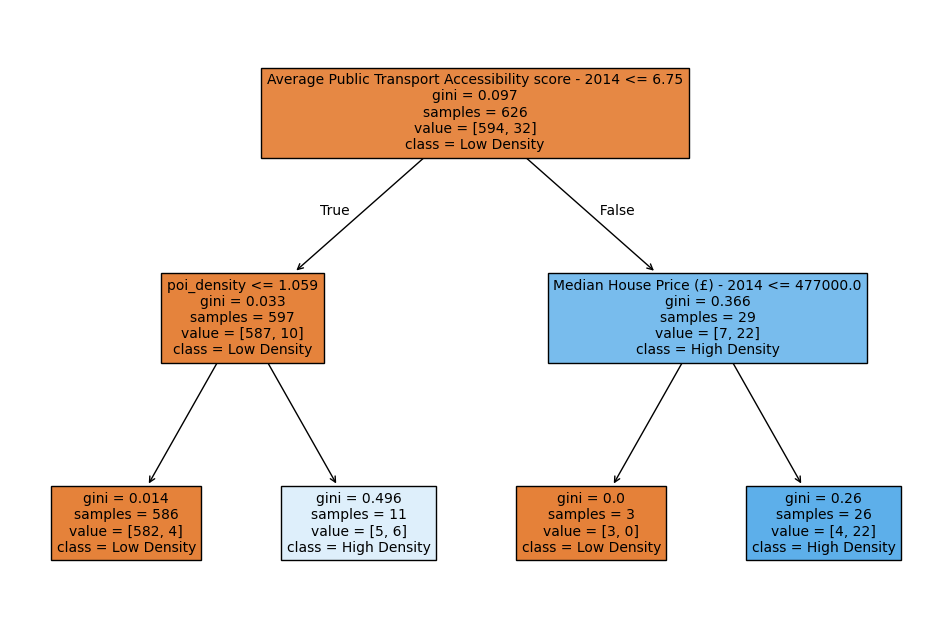

In [12]:
# Prepare data for the decision tree
X = ward_airbnb[['poi_density', 
                 'Average Public Transport Accessibility score - 2014', 
                 'Median House Price (£) - 2014', 
                 'Median Household income estimate (2012/13)']]  # dependent variables
y = ward_airbnb['high_airbnb_dens']

# Train a decision tree
tree = DecisionTreeClassifier(max_depth=2, random_state=42) # limited depth means model remains interpretable without overfitting, focusing on the most critical features.
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Low Density', 'High Density'], filled=True, fontsize=10)
plt.show()

#### Interpreting the Decision Tree !

The decision tree model identifies two scenarios where a ward is predicted to have a high Airbnb density:

- Transport Accessibility of more than 6.75 and a Median House Price of more than £477,000 

This suggest that high Airbnb density is linked to well-connected areas with above-average housing prices, making these areas attractive to short-term rental operators. 


**or** 


- Transport Accessibility of less than or equal to 6.75 and a point of interest density of more than 1.059 per hectare. 

This highlights that less well-connected areas can still attract Airbnb activity if they have a high concentration of attractions and amenities.




The tree structure and thresholds indicate that Public Transport Accessibility is the most important feature in classifying wards into low or high Airbnb density, followed by Median House Prices and POI Density. Income was not included in the model, suggesting that income may not be a significant predictor of Airbnb density in this context, or that its influence is overshadowed by more relevant factors like housing prices which may be more directly tied to Airbnb demand.



**What is the accuracy of this model?**

In [13]:
# Generate confusion matrix
#probably remove and only keep accuracy numbers for more word space.
ward_airbnb['predicted_high_airbnb_dens'] = tree.predict_proba(X)[:, 1] > 0.5


conf_matrix = confusion_matrix(
    ward_airbnb['high_airbnb_dens'], 
    ward_airbnb['predicted_high_airbnb_dens'], 
    labels=[True, False]
)

TP = conf_matrix[0, 0]  # True Positives
FN = conf_matrix[0, 1]  # False Negatives
FP = conf_matrix[1, 0]  # False Positives
TN = conf_matrix[1, 1]  # True Negatives

# Calculate accuracy metrics
overall_accuracy = (TP + TN) / (TP + TN + FP + FN)
high_airbnb_accuracy = (TP) / (TP + FN)


print(f"\nOverall Accuracy: {overall_accuracy:.2f} (Correctly predicted wards overall)")
print(f"High Airbnb Accuracy: {high_airbnb_accuracy:.2f} (Correctly predicted high Airbnb density wards)")


Overall Accuracy: 0.98 (Correctly predicted wards overall)
High Airbnb Accuracy: 0.88 (Correctly predicted high Airbnb density wards)


The overall model accuracy is 98% which indicates that given our included characteristics our model can correctly distinguish between high and low Airbnb density wards very accurately.

For predicting high airbnb density the model is less accurate but still impressive at 87.5%, correctly predicting 28/32 high airbnb dense wards and miscategorising 9 non-high airbnb dense wards as high-density.

However, the 9 wards that the model miscategorised as Airbnb dense are useful to us as that is what we can classify as at-risk, as our model thinks that they share similar characteristics to high-density wards.



In [14]:
# Add predictions to the GeoDataFrame
ward_airbnb['prediction'] = tree.predict_proba(X)[:, 1] > 0.5

# Generate the at-risk and too-late categories
at_risk = ward_airbnb[(ward_airbnb['high_airbnb_dens'] == False) & (ward_airbnb['prediction'] == True)]
too_late = ward_airbnb[ward_airbnb['high_airbnb_dens'] == True]

ward_airbnb['status'] = 'neither'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(too_late['Ward name']), 'status'] = 'too_late'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(at_risk['Ward name']), 'status'] = 'at_risk'


ward_names = at_risk['Ward name'].tolist()
print(f"These at-risk wards are: {', '.join(ward_names)}")


These at-risk wards are: Lambeth - Bishop's, Hammersmith and Fulham - Shepherd's Bush Green, Westminster - Vincent Square, Westminster - Warwick, Camden - Camden Town with Primrose Hill, Islington - St. Mary's, Islington - Bunhill, Islington - Finsbury Park, Hackney - Dalston


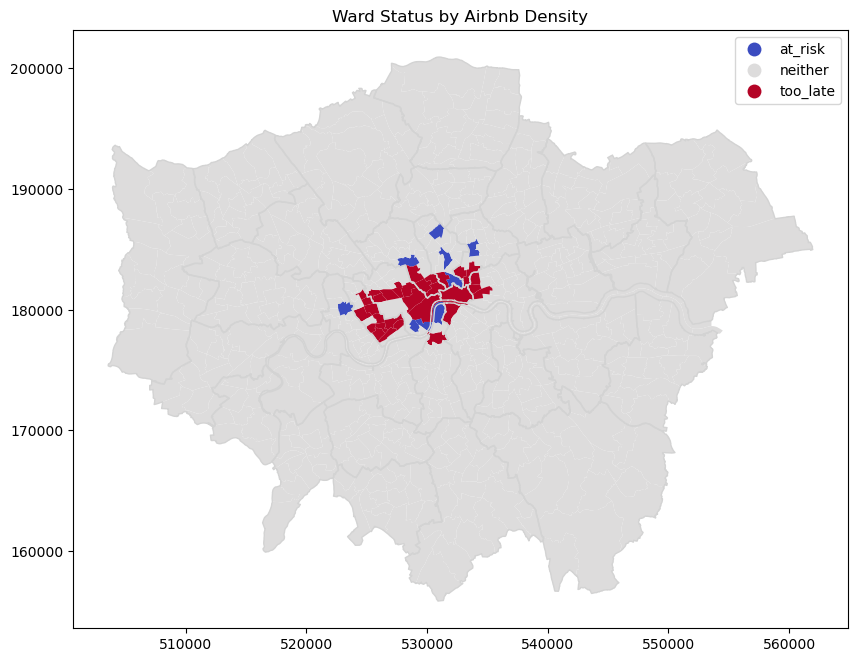

In [15]:
# Visualise at risk wards with a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ward_airbnb.plot(column='status', 
                 legend=True, 
                 cmap='coolwarm', 
                 ax=ax, 
                 legend_kwds={'bbox_to_anchor': (1, 1)})
plt.title("Ward Status by Airbnb Density")

boroughs.plot(
    edgecolor='lightgrey',    
    linewidth=1,         
    ax=ax,
    facecolor='none'      
)
plt.show()

#### Analysis of "At-Risk" Wards and Deprivation Rank

To assess potential social impact of Airbnb in London, we analyzed the relationship between our Airbnb decision tree classifications and deprivation rank in wards. Deprivation rank is a relative measure comparing the level of deprivation across London wards. The lower the deprivation rank, the greater the deprivation score in the ward. 

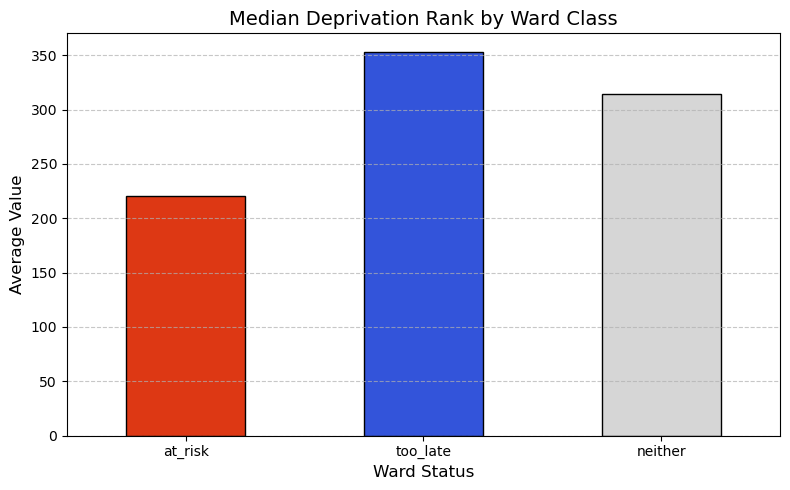

Median Deprivation Rank for 'at-risk' wards: 220.0
Median Deprivation Rank for 'too-late' wards: 352.5


/tmp/ipykernel_19957/843448259.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Median Deprivation Rank for 'at-risk' wards:", averages.loc['at_risk'][0])
/tmp/ipykernel_19957/843448259.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Median Deprivation Rank for 'too-late' wards:", averages.loc['too_late'][0])


In [21]:
# List of variables to analyze
variables = [
    '(ID2010) - Rank of average score (within London) - 2010']

# Custom order for the categories
category_order = ['at_risk', 'too_late', 'neither']

# Group the data by 'status' and calculate medians
#averages = ward_airbnb.groupby('status')[variables].median()
averages = ward_airbnb.groupby('status')[variables].median()

# Reindex to ensure the correct order of categories
averages = averages.reindex(category_order)

# Create individual bar plots for each variable
for var in variables:
    plt.figure(figsize=(8, 5))
    averages[var].plot(kind='bar', color=['#dd3814', '#3354da', '#d6d6d6'], edgecolor='black')

    # Customize the plot
    plt.title(f'Median Deprivation Rank by Ward Class', fontsize=14)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Ward Status', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

print("Median Deprivation Rank for 'at-risk' wards:", averages.loc['at_risk'][0])
print("Median Deprivation Rank for 'too-late' wards:", averages.loc['too_late'][0])

We begin with an exploratory data analysis of deprivation and classifications of Airbnb saturation for wards. This histogram shows the average deprivation rank between classification types. We see that the mean deprivation rank of “at-risk” wards is lower than “too-late” wards. This suggests that “at-risk” wards are not only desirable to Airbnb letters but are also particularly vulnerable to the negative impacts of Airbnb. 

The question remains, however, of where exactly the overlaps between at-risk wards and high deprivation occur. Spatial autocorrelation analysis of deprivation in London wards was employed in order to assess the spatial distribution of deprived wards in the city and examine which of our “at-risk” wards lay within high deprivation clusters. Cluster analysis improves the generalizability of the study by identifying patterns of deprivation beyond individual wards with arbitrary boundaries. 

In [23]:
from libpysal.weights import Queen
from esda import Moran

# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the variable '(ID2010) - Rank of average score (within London) - 2010' for the Moran test
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Global Moran's I
moran = Moran(y, w)

# Moran's I statistic
moran_I = moran.I
print(f"Global Moran's I: {moran_I}")

# p-value for the test
moran_p_value = moran.p_sim
print(f"p-value: {moran_p_value}")

Global Moran's I: 0.6888600665914413
p-value: 0.001


A Moran’s I test is conducted to establish that deprivation is not randomly distributed across wards in London. A Global Moran’s I statistic of 0.689 with a p-value less than 0.05 indicates there is statistically significant clustering of deprivation in London wards.

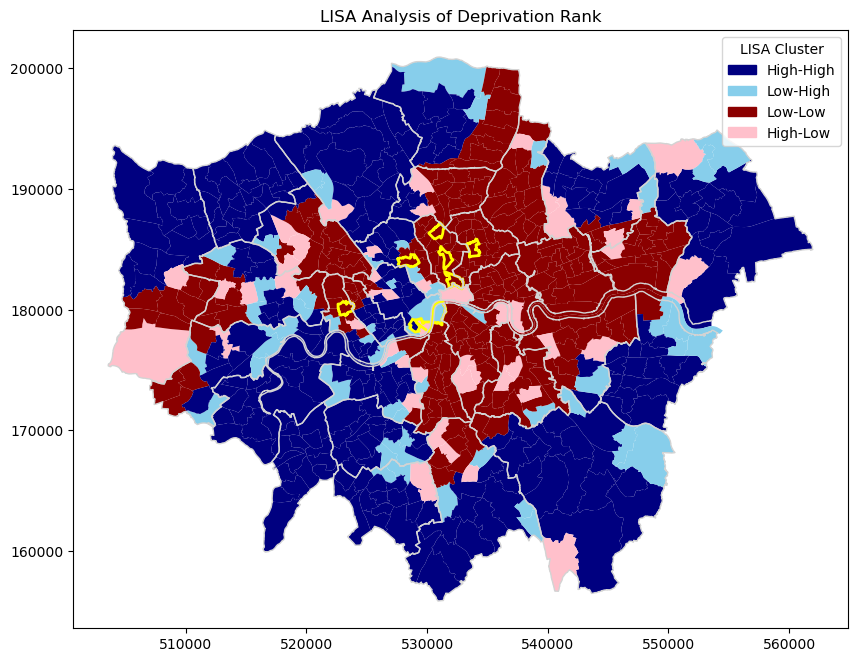

In [20]:
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = ward_airbnb[ward_airbnb['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Outline the wards with 'at_risk' status
boroughs.plot(
    edgecolor='lightgrey',    # Set black boundary for at-risk wards
    linewidth=1,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Deprivation Rank')
plt.show()

Local indicators of spatial autocorrelation (LISA) statistics allow us to visualize the clustering of deprivation in London. In the map produced, we see clear spatial clustering of deprivation rank in wards. Overlaying our “at-risk” wards, we see an overlap in deprivation clustering and “at-risk” in three wards in Islington, one in Hackney, one in Camden, and one in Hammersmith and Fulham.

#### Conclusion

The study concludes there are 9 wards “at-risk” of becoming heavily saturated by Airbnb. Furthermore, six of these wards are located within clusters of high deprivation. City policy focus on regulating and limiting Airbnbs in the the boroughs of Islington, Hackney, and Hammersmith and Fulham to mitigate the negative impacts of Airbnb on vulnerable populations. 